In [222]:
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor, as_completed
from concurrent.futures import Future 

In [223]:

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException, ElementNotVisibleException, TimeoutException, StaleElementReferenceException
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.common.action_chains import ActionChains

from datetime import datetime
import os
import json

In [224]:
import requests
import random
import time
from lxml import html
import pandas as pd
from pandas import ExcelWriter
import re

# Prepare categories

In [270]:
tikiURL = "https://tiki.vn/"
driver = webdriver.Firefox()

In [271]:
driver.get(tikiURL)

In [272]:
try:
    subscribeCancelXpath = '//button[@id="onesignal-slidedown-cancel-button"]'
    WebDriverWait(driver, 10, 0.5).until(EC.visibility_of_element_located((By.XPATH, subscribeCancelXpath)))
    driver.find_element_by_xpath(subscribeCancelXpath).click()
except:
    print('There is no subscription signal')
    driver.get(tikiURL)

In [273]:
# driver.set_window_size(1700, 1000)

In [275]:
driver.execute_script("document.body.style.transform='scale(0.8)';")

In [278]:
# Scroll down to categoryMenu
categoryMenuXpath = '//ul[@data-view-id="main_navigation"]'
WebDriverWait(driver, 100, 0.5).until(EC.visibility_of_element_located((By.XPATH, categoryMenuXpath)))
categoryMenu_e = driver.find_element_by_xpath(categoryMenuXpath)
driver.execute_script("arguments[0].scrollIntoView();", categoryMenu_e)

In [279]:
# Get categoryURLs and categoryNames
categoriesXpath = '//a[@class="menu-link"]'
WebDriverWait(driver, 100, 0.5).until(EC.visibility_of_element_located((By.XPATH, categoriesXpath)))
categories_e = driver.find_elements_by_xpath(categoriesXpath)
categoryURLs = [i.get_attribute('href') for i in categories_e ]
categoryNames = [i.text for i in categories_e ]
categoryURLs

['https://tiki.vn/dien-thoai-may-tinh-bang/c1789?src=c.1789.hamburger_menu_fly_out_banner',
 'https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner',
 'https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner',
 'https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner',
 'https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner',
 'https://tiki.vn/dien-gia-dung/c1882?src=c.1882.hamburger_menu_fly_out_banner',
 'https://tiki.vn/nha-cua-doi-song/c1883?src=c.1883.hamburger_menu_fly_out_banner',
 'https://tiki.vn/bach-hoa-online/c4384?src=c.4384.hamburger_menu_fly_out_banner',
 'https://tiki.vn/me-va-be/c2549?src=c.2549.hamburger_menu_fly_out_banner',
 'https://tiki.vn/lam-dep-suc-khoe/c1520?src=c.1520.hamburger_menu_fly_out_banner',
 'https://tiki.vn/#',
 'https://tiki.vn/the-thao/c1975?src=c.1975.hamburger_menu_fly_out_banner',
 'https://tiki.vn/o-to-xe-may-xe-dap/c8594?src=c.8594.hamb

In [281]:
# Functions to get catID and src for the API URLs to loop
def getcatID(categoryURLs):
    regexPattern1 = r'(?<=c)\d+(?=\?)'
    catIDs = [''.join(re.findall(regexPattern1, i)) for i in categoryURLs]
    return catIDs

def getsrc(categoryURLs):
    regexPattern2 = r'(?<=src=)c.+'
    srcs = [''.join(re.findall(regexPattern2, i)) for i in categoryURLs]
    return srcs

In [282]:
catIDs = getcatID(categoryURLs)
srcs = getsrc(categoryURLs)

In [283]:
# Function to get a dictionary of Categories
def getCategoryDict(categoryURLs, categoryNames, catIDs, srcs):
    categoryDict = {}
    for i in range(0, len(categoryURLs)):
        categoryDict[i] = {}
        categoryDict[i]['catName'] = categoryNames[i]
        categoryDict[i]['catURL'] = categoryURLs[i]
        categoryDict[i]['catID'] = catIDs[i]
        categoryDict[i]['catSrc'] = srcs[i]
    return categoryDict

In [284]:
categoryDict = getCategoryDict(categoryURLs, categoryNames, catIDs, srcs)

In [285]:
categoryDict

{0: {'catName': 'Điện Thoại - Máy Tính Bảng',
  'catURL': 'https://tiki.vn/dien-thoai-may-tinh-bang/c1789?src=c.1789.hamburger_menu_fly_out_banner',
  'catID': '1789',
  'catSrc': 'c.1789.hamburger_menu_fly_out_banner'},
 1: {'catName': 'Điện Tử - Điện Lạnh',
  'catURL': 'https://tiki.vn/tivi-thiet-bi-nghe-nhin/c4221?src=c.4221.hamburger_menu_fly_out_banner',
  'catID': '4221',
  'catSrc': 'c.4221.hamburger_menu_fly_out_banner'},
 2: {'catName': 'Phụ Kiện - Thiết Bị Số',
  'catURL': 'https://tiki.vn/thiet-bi-kts-phu-kien-so/c1815?src=c.1815.hamburger_menu_fly_out_banner',
  'catID': '1815',
  'catSrc': 'c.1815.hamburger_menu_fly_out_banner'},
 3: {'catName': 'Laptop - Thiết bị IT',
  'catURL': 'https://tiki.vn/laptop-may-vi-tinh/c1846?src=c.1846.hamburger_menu_fly_out_banner',
  'catID': '1846',
  'catSrc': 'c.1846.hamburger_menu_fly_out_banner'},
 4: {'catName': 'Máy Ảnh - Quay Phim',
  'catURL': 'https://tiki.vn/may-anh/c1801?src=c.1801.hamburger_menu_fly_out_banner',
  'catID': '180

In [286]:
# Get category that has empty URL
emptyIndices = [i for i, s in enumerate(categoryURLs) if '#' in s]
emptyCat = {}
for i in range(0, len(emptyIndices)):
    index = emptyIndices[i]
    emptyCat[i] = categoryDict[index]
    emptyCat[i]['emptyIndex'] = index
    emptyCat[i]['selenium_e'] = categories_e[index]

# Deal with empty categoryURL

In [288]:
emptyCat

{0: {'catName': 'Thời trang - Phụ kiện',
  'catURL': 'https://tiki.vn/#',
  'catID': '',
  'catSrc': '',
  'emptyIndex': 10,
  'selenium_e': <selenium.webdriver.firefox.webelement.FirefoxWebElement (session="cbc87d00-57e0-4cce-ac43-1f37bf1c7e38", element="f75d4310-0219-4c1d-9db0-069229460d3d")>}}

In [289]:
emptyCat_e = emptyCat[0]['selenium_e']
actionChains = ActionChains(driver)
hover = actionChains.move_to_element(emptyCat_e).click().perform()

In [290]:
submenuXpath = './parent::li/div[@class="SubMenu__NavSub-ykxlng-0 hlkIUF header-sub-menu"]//span[not(@class="SubMenu__NavSubItem-ykxlng-1 iethhs")]//a'
submenus_e = emptyCat_e.find_elements_by_xpath(submenuXpath)
if len(submenus_e ) == 0:
    while len(submenus_e ) == 0:
        submenus_e = emptyCat_e.find_elements_by_xpath(submenuXpath)
submenuURLs = [i.get_attribute('href') for i in submenus_e]
submenuNames = [i.text for i in submenus_e ]

In [293]:
subcatIDs = getcatID(submenuURLs)
subcatSrcs = getsrc(submenuURLs)
subCategoryDict = getCategoryDict(submenuURLs, submenuNames, subcatIDs, subcatSrcs)

In [294]:
subCategoryDict

{0: {'catName': 'THỜI TRANG NỮ',
  'catURL': 'https://tiki.vn/thoi-trang-nu/c931?src=c.931.hamburger_menu_fly_out_banner',
  'catID': '931',
  'catSrc': 'c.931.hamburger_menu_fly_out_banner'},
 1: {'catName': 'GIÀY DÉP NỮ',
  'catURL': 'https://tiki.vn/giay-dep-nu/c1703?src=c.1703.hamburger_menu_fly_out_banner',
  'catID': '1703',
  'catSrc': 'c.1703.hamburger_menu_fly_out_banner'},
 2: {'catName': 'TÚI THỜI TRANG NỮ',
  'catURL': 'https://tiki.vn/tui-vi-nu/c976?src=c.976.hamburger_menu_fly_out_banner',
  'catID': '976',
  'catSrc': 'c.976.hamburger_menu_fly_out_banner'},
 3: {'catName': 'THỜI TRANG NAM',
  'catURL': 'https://tiki.vn/thoi-trang-nam/c915?src=c.915.hamburger_menu_fly_out_banner',
  'catID': '915',
  'catSrc': 'c.915.hamburger_menu_fly_out_banner'},
 4: {'catName': 'GIÀY DÉP NAM',
  'catURL': 'https://tiki.vn/giay-dep-nam/c1686?src=c.1686.hamburger_menu_fly_out_banner',
  'catID': '1686',
  'catSrc': 'c.1686.hamburger_menu_fly_out_banner'},
 5: {'catName': 'TÚI THỜI TRANG

# Requests

## Functions

In [17]:
ua = ['Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; Trident/4.0; InfoPath.2; SV1; .NET CLR 2.0.50727; WOW64)', 'Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 6.1; Trident/4.0; GTB7.4; InfoPath.2; SV1; .NET CLR 3.3.69573; WOW64; en-US)', 'Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 5.1; Trident/4.0; .NET CLR 1.1.4322; .NET CLR 2.0.50727)', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0; chromeframe/13.0.782.215)', 'Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 6.0; Trident/4.0; .NET CLR 2.7.58687; SLCC2; Media Center PC 5.0; Zune 3.4; Tablet PC 3.6; InfoPath.3)', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 7.1; Trident/5.0)', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; .NET CLR 3.5.30729; .NET CLR 3.0.30729; .NET CLR 2.0.50727; Media Center PC 6.0)', 'Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 6.0; Trident/4.0; WOW64; Trident/4.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; .NET CLR 1.0.3705; .NET CLR 1.1.4322)', 'Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.1; WOW64; Trident/4.0; SLCC2; Media Center PC 6.0; InfoPath.2; MS-RTC LM 8)', 'Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 5.2; Trident/4.0; Media Center PC 4.0; SLCC1; .NET CLR 3.0.04320)', 'Mozilla/5.0 (Windows; U; MSIE 9.0; WIndows NT 9.0; en-US))', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0) chromeframe/10.0.648.205', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; InfoPath.2; .NET CLR 1.1.4322; .NET4.0C; Tablet PC 2.0)', 'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; WOW64; Trident/6.0)', 'Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 5.1; Trident/4.0; InfoPath.2; SLCC1; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729; .NET CLR 2.0.50727)', 'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; Trident/5.0)', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; SLCC2; Media Center PC 6.0; InfoPath.3; MS-RTC LM 8; Zune 4.7', 'Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.1; WOW64; Trident/4.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; Zune 3.0)', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/4.0; GTB7.4; InfoPath.1; SV1; .NET CLR 2.8.52393; WOW64; en-US)', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0; yie8)', 'Mozilla/5.0 (compatible; MSIE 10.0; Macintosh; Intel Mac OS X 10_7_3; Trident/6.0)', 'Mozilla/5.0 (compatible, MSIE 11, Windows NT 6.3; Trident/7.0; rv:11.0) like Gecko', 'Mozilla/4.0 (compatible; MSIE 10.0; Windows NT 6.1; Trident/5.0)', 'Mozilla/5.0 (compatible; MSIE 7.0; Windows NT 5.0; Trident/4.0; FBSMTWB; .NET CLR 2.0.34861; .NET CLR 3.0.3746.3218; .NET CLR 3.5.33652; msn OptimizedIE8;ENUS)', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; SLCC2; Media Center PC 6.0; InfoPath.3; MS-RTC LM 8; Zune 4.7)', 'Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.1; WOW64; Trident/4.0; SLCC2; .NET CLR 2.0.50727; InfoPath.2)', 'Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.1; WOW64; Trident/4.0; SLCC2; Media Center PC 6.0; InfoPath.2; MS-RTC LM 8', 'Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 5.1; SLCC1; .NET CLR 1.1.4322)', 'Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; AS; rv:11.0) like Gecko', 'Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 5.0; Trident/4.0; InfoPath.1; SV1; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729; .NET CLR 3.0.04506.30)', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0; FunWebProducts)', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0; chromeframe/11.0.696.57)', 'Mozilla/5.0 (Windows; U; MSIE 9.0; Windows NT 9.0; en-US)', 'Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.2; Trident/4.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0)', 'Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 6.0; Trident/4.0; InfoPath.1; SV1; .NET CLR 3.8.36217; WOW64; en-US)', 'Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.1; WOW64; Trident/4.0; SLCC2; .NET CLR 2.0.50727; Media Center PC 6.0; .NET CLR 3.5.30729; .NET CLR 3.0.30729; .NET4.0C)', 'Mozilla/5.0 (compatible; MSIE 8.0; Windows NT 5.1; Trident/4.0; SLCC1; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729; .NET CLR 1.1.4322)', 'Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.1; WOW64; Trident/4.0; SLCC2; .NET CLR 2.0.50727; InfoPath.3; .NET4.0C; .NET4.0E; .NET CLR 3.5.30729; .NET CLR 3.0.30729; MS-RTC LM 8)', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.0; Trident/4.0; GTB7.4; InfoPath.3; SV1; .NET CLR 3.1.76908; WOW64; en-US)', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Win64; x64; Trident/5.0', 'Mozilla/4.0 (Compatible; MSIE 8.0; Windows NT 5.2; Trident/6.0)', 'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; Trident/6.0)', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; chromeframe/12.0.742.112)', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; Zune 4.0; InfoPath.3; MS-RTC LM 8; .NET4.0C; .NET4.0E)', 'Mozilla/5.0 (compatible; MSIE 10.6; Windows NT 6.1; Trident/5.0; InfoPath.2; SLCC1; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729; .NET CLR 2.0.50727) 3gpp-gba UNTRUSTED/1.0', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.0; Trident/5.0; chromeframe/11.0.696.57)', 'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 7.0; InfoPath.3; .NET CLR 3.1.40767; Trident/6.0; en-IN)', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Win64; x64; Trident/5.0; .NET CLR 3.5.30729; .NET CLR 3.0.30729; .NET CLR 2.0.50727; Media Center PC 6.0)', 'Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Win64; x64; Trident/5.0; .NET CLR 2.0.50727; SLCC2; .NET CLR 3.5.30729; .NET CLR 3.0.30729; Media Center PC 6.0; Zune 4.0; Tablet PC 2.0; InfoPath.3; .NET4.0C; .NET4.0E)', 'Mozilla/1.22 (compatible; MSIE 10.0; Windows 3.1)', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24.0) Gecko/20100101 Firefox/24.0', 'Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:16.0.1) Gecko/20121011 Firefox/21.0.1', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:21.0) Gecko/20100101 Firefox/21.0', 'Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16.0.1) Gecko/20121011 Firefox/21.0.1', 'Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Gecko/20100101 Firefox/28.0', 'Mozilla/5.0 (Windows NT 6.3; rv:36.0) Gecko/20100101 Firefox/36.0', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:10.0) Gecko/20100101 Firefox/62.0', 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:21.0) Gecko/20130401 Firefox/21.0', 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:64.0) Gecko/20100101 Firefox/64.0', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10; rv:33.0) Gecko/20100101 Firefox/33.0', 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:40.0) Gecko/20100101 Firefox/40.1', 'Mozilla/5.0 (X11; Linux i586; rv:63.0) Gecko/20100101 Firefox/63.0', 'Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:21.0.0) Gecko/20121011 Firefox/21.0.0', 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Firefox/58.0.1', 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20130401 Firefox/31.0', 'Mozilla/5.0 (Windows NT 6.2; rv:20.0) Gecko/20121202 Firefox/26.0', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.8; rv:24.0) Gecko/20100101 Firefox/24.0', 'Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/20100101 Firefox/31.0', 'Mozilla/5.0 (Windows NT 6.2; WOW64; rv:63.0) Gecko/20100101 Firefox/63.0', 'Mozilla/5.0 (Windows NT 6.2; rv:22.0) Gecko/20130405 Firefox/22.0', 'Mozilla/5.0 (Windows NT 6.1; rv:22.0) Gecko/20130405 Firefox/22.0', 'Mozilla/5.0 (Windows NT 6.2; rv:21.0) Gecko/20130326 Firefox/21.0', 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:54.0) Gecko/20100101 Firefox/58.0', 'Mozilla/5.0 (X11; Linux i686; rv:21.0) Gecko/20100101 Firefox/21.0', 'Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:27.0) Gecko/20121011 Firefox/27.0', 'Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.9a1) Gecko/20060814 Firefox/51.0', 'Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:22.0) Gecko/20130328 Firefox/22.0', 'Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25.0) Gecko/20100101 Firefox/29.0', 'Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:28.0) Gecko/20100101 Firefox/31.0', 'Mozilla/5.0 (Windows NT 10.0; WOW64; rv:45.66.18) Gecko/20177177 Firefox/45.66.18', 'Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25.0) Gecko/20100101 Firefox/25.0', 'Mozilla/5.0 (Windows NT 6.3; WOW64; rv:52.59.12) Gecko/20160044 Firefox/52.59.12', 'Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20130101 Firefox/27.3', 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:21.0) Gecko/20130330 Firefox/21.0', 'Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:23.0) Gecko/20131011 Firefox/23.0', 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:21.0) Gecko/20130331 Firefox/21.0', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; rv:25.0) Gecko/20100101 Firefox/25.0', 'Mozilla/5.0 (Windows NT 6.0; WOW64; rv:24.0) Gecko/20100101 Firefox/24.0', 'Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10.13; ko; rv:1.9.1b2) Gecko/20081201 Firefox/60.0', 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:23.0) Gecko/20130406 Firefox/23.0', 'Mozilla/5.0 (X11; Linux i686; rv:64.0) Gecko/20100101 Firefox/64.0', 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:46.0) Gecko/20120121 Firefox/46.0', 'Mozilla/5.0 (Microsoft Windows NT 6.2.9200.0); rv:22.0) Gecko/20130405 Firefox/22.0', 'Mozilla/5.0 (Windows NT 6.2; WOW64; rv:21.0) Gecko/20130514 Firefox/21.0', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:21.0) Gecko/20130331 Firefox/21.0', 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:29.0) Gecko/20120101 Firefox/29.0', 'Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20100101 Firefox/31.0', 'Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10.10; rv:62.0) Gecko/20100101 Firefox/62.0', 'Mozilla/5.0 (Windows NT 6.2; rv:22.0) Gecko/20130405 Firefox/23.0', 'Mozilla/5.0 (X11; Linux x86_64; rv:28.0) Gecko/20100101 Firefox/28.0', 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/29.0.1547.62 Safari/537.36',
      'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1312.60 Safari/537.17', 'Mozilla/5.0 (X11; NetBSD) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.116 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.90 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/28.0.1464.0 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1664.3 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/30.0.1599.17 Safari/537.36', 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/34.0.1847.137 Safari/4E423F', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.2309.372 Safari/537.36', 'Mozilla/5.0 (Windows NT 4.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2049.0 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1944.0 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/29.0.1547.2 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.3319.102 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/28.0.1467.0 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.0 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/34.0.1847.116 Safari/537.36 Mozilla/5.0 (iPad; U; CPU OS 3_2 like Mac OS X; en-us) AppleWebKit/531.21.10 (KHTML, like Gecko) Version/4.0.4 Mobile/7B334b Safari/531.21.10', 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.517 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/31.0.1650.16 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/34.0.1866.237 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1664.3 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2226.0 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.1 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.124 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/28.0.1468.0 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.2; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1667.0 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML like Gecko) Chrome/44.0.2403.155 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.4; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2225.0 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.67 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_2) AppleWebKit/537.17 (KHTML, like Gecko) Chrome/24.0.1309.0 Safari/537.17', 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/31.0.1623.0 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.2117.157 Safari/537.36', 'Mozilla/5.0 (X11; CrOS i686 4319.74.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/29.0.1547.57 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36', 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36', 'Mozilla/5.0 (X11; CrOS i686 3912.101.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.116 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1500.55 Safari/537.36', 'Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/40.0.2214.93 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2049.0 Safari/537.36', 'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2225.0 Safari/537.36', 'Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2224.3 Safari/537.36', 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2227.0 Safari/537.36', 'Mozilla/5.0 (X11; OpenBSD i386) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36']
s = requests.session()

s_headers={"Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3",
         "Accept-Language":"en,vi-VN;q=0.9,vi;q=0.8,fr-FR;q=0.7,fr;q=0.6,en-US;q=0.5",
         "Content-Type":"application/x-www-form-urlencoded",
         "Upgrade-Insecure-Requests":"1",
         "User-Agent" : random.choice(ua),
        }

s.headers = s_headers

In [403]:
# Functions to get catID and src for the API URLs to loop
def getPageNum(URL):
    regexPattern1 = r'(?<=page=).*(?=&)'
    pageNum = ''.join(re.findall(regexPattern1, URL))
    return pageNum


In [404]:
def getJson(url):
    start = time.time()
    pageNum = getPageNum(url)
    print(pageNum)
    resp = s.get(url)
    respJson = resp.json()
    time.sleep(5)
    end = time.time()
    print("Time to getJson each URL: {:.6f}s".format(end-start))
    return respJson

In [405]:
def getPageURL(catID, page, catSrc):
    pageURL = 'https://tiki.vn/api/v2/products?limit=48' + \
                '&aggregations=1' + \
                '&category='+ catID + \
                '&page=' + str(page) + \
                '&src=' + catSrc
    return pageURL

pageURL = getPageURL(categoryDict[0]["catID"],  1, categoryDict[0]["catSrc"])
pageURL

'https://tiki.vn/api/v2/products?limit=48&aggregations=1&category=1789&page=1&src=c.1789.hamburger_menu_fly_out_banner'

In [377]:
eg = getJson(pageURL)

Time Taken of getJson each URL: 5.551580s


In [406]:
def getallJsonData(categoryDict):
    global allJsonData
    allJsonData = []
    start0 = time.time()
    for nCat in range(0, len(categoryDict)):
        if categoryDict[nCat]["catID"] == '':
            pass
        else:
            print('\n\n\n', categoryDict[nCat]['catName'])

            # Get first page
            page = 1
            pageURL = getPageURL(categoryDict[nCat]["catID"],  page, categoryDict[nCat]["catSrc"])
            respJson = getJson(pageURL)
            lastPage = respJson['paging']['last_page']
            respData = respJson['data']
            # Loop through each item in first page
            for nPage in range(0,len(respData)):
                respData[nPage]['Web_Category'] = categoryDict[nCat]['catName']
                respData[nPage]['Page_Loop'] = page
            allJsonData.append(respData)
            print('lastPage', lastPage)
            
            # Get second -> last page
            pageURLs = [getPageURL(categoryDict[nCat]["catID"],  page, categoryDict[nCat]["catSrc"]) for page in range(2, lastPage+1)]

            ## Multithreading     
            with ThreadPoolExecutor(max_workers=3) as executor:
                start = time.time()
                for jsonFile in executor.map(getJson, pageURLs):
                    respData = jsonFile['data']
                    print('\n Total items in this page: ', len(respData))

                    if len(respData) == 0: #If response has "data = []""
                        print('data = []')
                        break    
                        
                    else: # If response has data
                        # Loop thourgh each items of reponse
                        for eachItem in range(0, len(respData)):
                            respData[eachItem]['Web_Category'] = categoryDict[nCat]['catName']
                            respData[eachItem]['Page_Loop'] = jsonFile['paging']['current_page']
                        allJsonData.append(respData)
                        end = time.time()
                        print("Time of getting respData: {:.6f}s".format(end-start))
    end0 = time.time()
    print("Total loop time taken: {:.6f}s".format(end0-start0))
    return allJsonData

## Main Categories

In [407]:
resultData = getallJsonData(categoryDict)




 Điện Thoại - Máy Tính Bảng
1
Time to getJson each URL: 5.140828s
lastPage 9
2
3
4
Time to getJson each URL: 5.122840s
5
Time to getJson each URL: 5.139830s
6
 Total items in this page:  48
Time of getting respData: 5.140829s

Time to getJson each URL: 5.169809s
7
 Total items in this page:  48
Time of getting respData: 5.174809s

 Total items in this page:  48
Time of getting respData: 5.174809s

Time to getJson each URL: 5.116843s
8
 Total items in this page:  48
Time of getting respData: 10.248678s

Time to getJson each URL: 5.118842s
9
 Total items in this page:  48
Time of getting respData: 10.259671s

Time to getJson each URL: 5.090860s

 Total items in this page:  48
Time of getting respData: 10.265668s
Time to getJson each URL: 5.077867s

 Total items in this page:  48
Time of getting respData: 15.326545s
Time to getJson each URL: 5.114844s

 Total items in this page:  41
Time of getting respData: 15.375515s



 Điện Tử - Điện Lạnh
1
Time to getJson each URL: 5.116843s
lastP

Time to getJson each URL: 5.111848s
lastPage 198
2
3
4
Time to getJson each URL: 5.106849s
5
 Total items in this page:  48
Time of getting respData: 5.107847s

Time to getJson each URL: 5.121839s
6
Time to getJson each URL: 5.149822s
7
 Total items in this page:  
48
Time of getting respData: 5.155819s

 Total items in this page:  48
Time of getting respData: 5.157818s
Time to getJson each URL: 5.110847s
8
 Total items in this page:  48
Time of getting respData: 10.218695s

Time to getJson each URL: 5.083865s
9
Time to getJson each URL: 5.620532s
10
 Total items in this page:  48
Time of getting respData: 10.750367s

 Total items in this page:  48
Time of getting respData: 10.750367s

Time to getJson each URL: 5.124839s
11
 Total items in this page:  48
Time of getting respData: 15.344533s

Time to getJson each URL: 5.111845s
12
 Total items in this page:  
48
Time of getting respData: 15.350530s
Time to getJson each URL: 5.073872s
13
 Total items in this page:  48
Time of getting res

Time to getJson each URL: 5.167810s
14
 Total items in this page:  48
Time of getting respData: 20.652260s

Time to getJson each URL: 5.159817s
15
 Total items in this page:  48
Time of getting respData: 20.678242s

Time to getJson each URL: 5.174809s
16
 Total items in this page:  48
Time of getting respData: 21.171938s

Time to getJson each URL: 5.168811s
17

 Total items in this page:  48
Time of getting respData: 25.820070s
Time to getJson each URL: 5.165813s
18
 Total items in this page:  48
Time of getting respData: 25.844057s

Time to getJson each URL: 5.173807s
19
 Total items in this page:  48
Time of getting respData: 26.345745s

Time to getJson each URL: 5.154823s
20
 Total items in this page:  48
Time of getting respData: 30.975891s

Time to getJson each URL: 5.187800s
21
 Total items in this page:  
48
Time of getting respData: 31.031856s
Time to getJson each URL: 5.182803s
22
 Total items in this page:  48
Time of getting respData: 31.528550s

Time to getJson each URL: 5.

Time to getJson each URL: 5.170809s
23
 Total items in this page:  48
Time of getting respData: 36.257628s

Time to getJson each URL: 5.190797s
24
 Total items in this page:  40
Time of getting respData: 36.308596s

Time to getJson each URL: 5.100852s
25
 Total items in this page:  0

data = []
Time to getJson each URL: 5.094857s
Time to getJson each URL: 5.069872s
Time to getJson each URL: 5.071870s



 Xe Máy, Ô tô, Xe Đạp
1
Time to getJson each URL: 5.335708s
lastPage 209
2
3
4
Time to getJson each URL: 5.176806s
5

 Total items in this page:  48
Time of getting respData: 5.179803s
Time to getJson each URL: 5.179804s
6
Time to getJson each URL: 5.189798s
7
 Total items in this page:  
48
Time of getting respData: 5.195793s

 Total items in this page:  48
Time of getting respData: 5.197791s
Time to getJson each URL: 5.198793s
8
 Total items in this page:  48
Time of getting respData: 10.377598s

Time to getJson each URL: 5.194794s
9
 Total items in this page:  48
Time of getting resp

Time to getJson each URL: 5.228774s
10
 Total items in this page: 
 48
Time of getting respData: 10.932256s
Time to getJson each URL: 5.203333s
11
 Total items in this page:  48
Time of getting respData: 15.513973s

Time to getJson each URL: 5.537125s
12
 Total items in this page:  48
Time of getting respData: 15.981683s

Time to getJson each URL: 5.262298s
13
 Total items in this page:  48
Time of getting respData: 16.191554s

Time to getJson each URL: 5.265751s
14
 Total items in this page:  48
Time of getting respData: 20.779723s

Time to getJson each URL: 5.273745s
15
 Total items in this page:  48
Time of getting respData: 21.255430s

Time to getJson each URL: 5.173807s
16
 Total items in this page:  48
Time of getting respData: 21.365362s

Time to getJson each URL: 5.206788s
17
 Total items in this page:  48
Time of getting respData: 25.986511s

Time to getJson each URL: 5.292734s
18
 Total items in this page:  48
Time of getting respData: 26.548164s

Time to getJson each URL: 5.

In [383]:
len(resultData)

2767

## Sub-categories

In [421]:
resultData_sub = getallJsonData(subCategoryDict)




 THỜI TRANG NỮ
1
Time to getJson each URL: 5.538581s
lastPage 209
2
34

Time to getJson each URL: 5.181803s
5
 Total items in this page:  
48
Time of getting respData: 5.184801s
Time to getJson each URL: 5.349697s
6
 Total items in this page:  48
Time of getting respData: 5.354695s

Time to getJson each URL: 5.464627s
7
 Total items in this page:  48
Time of getting respData: 5.473624s

Time to getJson each URL: 5.190797s
8
 Total items in this page:  48
Time of getting respData: 10.375598s

Time to getJson each URL: 5.186800s
9

 Total items in this page:  48
Time of getting respData: 10.544494s
Time to getJson each URL: 5.391674s
10
 Total items in this page:  48
Time of getting respData: 10.865297s

Time to getJson each URL: 5.173808s
11
 Total items in this page:  48
Time of getting respData: 15.549406s

Time to getJson each URL: 5.170810s
12

 Total items in this page:  48
Time of getting respData: 15.714304s
Time to getJson each URL: 5.333708s
13
 Total items in this page:  48

Time to getJson each URL: 5.163813s
14

 Total items in this page:  48
Time of getting respData: 20.682237s
Time to getJson each URL: 5.176806s
15
 Total items in this page:  48
Time of getting respData: 20.718215s

Time to getJson each URL: 5.192795s
16
 Total items in this page:  48
Time of getting respData: 20.771181s

Time to getJson each URL: 5.187798s
17
 Total items in this page:  
48
Time of getting respData: 25.872035s
Time to getJson each URL: 5.186799s
18
 Total items in this page:  48
Time of getting respData: 25.906014s

Time to getJson each URL: 5.165813s
19
 Total items in this page:  48
Time of getting respData: 25.936994s

Time to getJson each URL: 5.166811s
20
 Total items in this page:  48
Time of getting respData: 31.037846s

Time to getJson each URL: 5.193794s
21
 Total items in this page:  48
Time of getting respData: 31.099808s

Time to getJson each URL: 5.186798s
22
 Total items in this page:  48
Time of getting respData: 31.123792s

Time to getJson each URL: 5.

Time to getJson each URL: 5.157817s
23
 Total items in this page:  48
Time of getting respData: 36.016773s

Time to getJson each URL: 5.135831s
24
 Total items in this page:  40
Time of getting respData: 36.033762s

Time to getJson each URL: 5.070870s
25
 Total items in this page:  0
data = []

Time to getJson each URL: 5.076868s
Time to getJson each URL: 5.085862s
Time to getJson each URL: 5.096855s



 PHỤ KIỆN
1
Time to getJson each URL: 5.538580s
lastPage 209
2
3
4
Time to getJson each URL: 5.134832s
5
 Total items in this page:  48
Time of getting respData: 5.136831s

Time to getJson each URL: 5.184799s
6
Time to getJson each URL: 5.678494s
7
 Total items in this page:  48
Time of getting respData: 5.683493s

 Total items in this page:  48
Time of getting respData: 5.683493s

Time to getJson each URL: 5.157818s
8
 Total items in this page:  48
Time of getting respData: 10.294648s

Time to getJson each URL: 5.164812s
9
 Total items in this page:  48
Time of getting respData: 10.357

In [422]:
len(resultData_sub)

189

# Export

In [408]:
def getOutFileName(outPath, filename):
    # Check & Create Directory
    if not os.path.exists(outPath):
        print('Creating new directory...')
        os.makedirs(outPath)
        
    # Initial path
    nFile = 1
    
    name = filename.split('.')[0]
    extension = filename.split('.')[1]
    newfilename = name + str(nFile) + '.' + extension
    
    finalPath = os.path.join(outPath, newfilename)
    
    # Loop & Check if file name exists -> jsonPath
    while os.path.exists(finalPath):
        nFile += 1
        newfilename = name + str(nFile) + '.' + extension
        finalPath = os.path.join(outPath, newfilename)
    print(finalPath)
    return finalPath

In [409]:
def ToJson(jsonPath, listJson):
    # Export to Json
    with open(jsonPath, 'w') as outfile:
        json.dump(listJson, outfile)

In [410]:
def toXlsx(outPath, filename, df):
    # Get finalPath
    finalPath = getOutFileName(outPath, filename)

    # Export to xlsx file
    with ExcelWriter (finalPath, options={'strings_to_urls': False}) as writer:
        df.to_excel (writer, index = False)

## Export to Json

In [424]:
outPath_json1 = 'D:\AP\Python\Scrapy\JsonOutput'
filename_json1 = 'resultData.json'
resultDataPath = getOutFileName(outPath_json1, filename_json1)
ToJson(resultDataPath, resultData)

D:\AP\Python\Scrapy\JsonOutput\resultData1.json


In [425]:
outPath_json2 = 'D:\AP\Python\Scrapy\JsonOutput'
filename_json2 = 'resultData_sub.json'
resultData_subPath = getOutFileName(outPath_json2, filename_json2)
ToJson(resultData_subPath, resultData_sub)

D:\AP\Python\Scrapy\JsonOutput\resultData_sub1.json


## Merge into Total Dataframe

In [426]:
# Read Json file
with open(resultDataPath, "r") as readfile:
    resultDataJson = json.load(readfile)

In [427]:
# Read Json file
with open(resultData_subPath, "r") as readfile:
    resultData_subJson = json.load(readfile)

In [428]:
outPath = 'D:\AP\Python\Scrapy\mergeDF'
filename = 'mergeDF.xlsx'

mergeDFpath = getOutFileName(outPath, filename)

D:\AP\Python\Scrapy\mergeDF\mergeDF1.xlsx


In [429]:
merge_df = pd.DataFrame()
for npage in range(0, len(resultDataJson)):
    print('resultData: ', npage + 1, '/', len(resultDataJson))
    df = pd.DataFrame(resultDataJson[npage])
    merge_df = pd.concat([merge_df, df], ignore_index=True, axis = 0)

resultData:  1 / 303
resultData:  2 / 303
resultData:  3 / 303
resultData:  4 / 303
resultData:  5 / 303
resultData:  6 / 303
resultData:  7 / 303
resultData:  8 / 303
resultData:  9 / 303
resultData:  10 / 303
resultData:  11 / 303
resultData:  12 / 303
resultData:  13 / 303
resultData:  14 / 303
resultData:  15 / 303
resultData:  16 / 303
resultData:  17 / 303
resultData:  18 / 303
resultData:  19 / 303
resultData:  20 / 303
resultData:  21 / 303
resultData:  22 / 303
resultData:  23 / 303
resultData:  24 / 303
resultData:  25 / 303
resultData:  26 / 303
resultData:  27 / 303
resultData:  28 / 303
resultData:  29 / 303
resultData:  30 / 303
resultData:  31 / 303
resultData:  32 / 303
resultData:  33 / 303
resultData:  34 / 303
resultData:  35 / 303
resultData:  36 / 303
resultData:  37 / 303
resultData:  38 / 303
resultData:  39 / 303
resultData:  40 / 303
resultData:  41 / 303
resultData:  42 / 303
resultData:  43 / 303
resultData:  44 / 303
resultData:  45 / 303
resultData:  46 / 3

In [430]:
for npage in range(0, len(resultData_subJson)):
    print('resultData_sub: ', npage, '/', len(resultData_subJson))
    df = pd.DataFrame(resultData_subJson[npage])
    merge_df = pd.concat([merge_df, df], ignore_index=True, axis = 0)

resultData_sub:  0 / 189
resultData_sub:  1 / 189
resultData_sub:  2 / 189
resultData_sub:  3 / 189
resultData_sub:  4 / 189
resultData_sub:  5 / 189
resultData_sub:  6 / 189
resultData_sub:  7 / 189
resultData_sub:  8 / 189
resultData_sub:  9 / 189
resultData_sub:  10 / 189
resultData_sub:  11 / 189
resultData_sub:  12 / 189
resultData_sub:  13 / 189
resultData_sub:  14 / 189
resultData_sub:  15 / 189
resultData_sub:  16 / 189
resultData_sub:  17 / 189
resultData_sub:  18 / 189
resultData_sub:  19 / 189
resultData_sub:  20 / 189
resultData_sub:  21 / 189
resultData_sub:  22 / 189
resultData_sub:  23 / 189
resultData_sub:  24 / 189
resultData_sub:  25 / 189
resultData_sub:  26 / 189
resultData_sub:  27 / 189
resultData_sub:  28 / 189
resultData_sub:  29 / 189
resultData_sub:  30 / 189
resultData_sub:  31 / 189
resultData_sub:  32 / 189
resultData_sub:  33 / 189
resultData_sub:  34 / 189
resultData_sub:  35 / 189
resultData_sub:  36 / 189
resultData_sub:  37 / 189
resultData_sub:  38 / 

In [431]:
merge_df

,id,sku,name,url_key,url_path,type,brand_name,short_description,price,list_price,...,stock_item,salable_type,seller_product_id,Web_Category,Page_Loop,installment_info,bundle_deal,freegift_items,author_name,book_cover
0,25730627,7578609335289,Điện Thoại Nokia 105 Dual Sim (2019) - Hàng Ch...,dien-thoai-nokia-105-dual-sim-2019-hang-chinh-...,dien-thoai-nokia-105-dual-sim-2019-hang-chinh-...,configurable,Nokia,"Thiết kế nhỏ gọn, đẹp mắt\nĐiện Thoại Nokia 10...",321000,360000,...,"{'qty': 82, 'min_sale_qty': 1, 'max_sale_qty':...",,42932547,Điện Thoại - Máy Tính Bảng,1,NaN,NaN,NaN,NaN,NaN
1,37694867,9953326620289,Điện thoại Vivo Y11 (3GB/32GB) - Hàng chính hãng,dien-thoai-vivo-y11-hang-chinh-hang-p37694867,dien-thoai-vivo-y11-hang-chinh-hang-p37694867....,configurable,Vivo,"Thiết kế sang trọng, sắc màu huyền ảo\nĐiện th...",2550000,2990000,...,"{'qty': 46, 'min_sale_qty': 1, 'max_sale_qty':...",,37694871,Điện Thoại - Máy Tính Bảng,1,NaN,NaN,NaN,NaN,NaN
2,71197117,6411469851647,Điện Thoại iPhone 12 Pro Max 256GB - Hàng Chín...,dien-thoai-iphone-12-pro-max-256gb-hang-chinh-...,dien-thoai-iphone-12-pro-max-256gb-hang-chinh-...,configurable,Apple,iPhone 12 Pro Max 256GB - Nâng tầm đẳng cấp sử...,35490000,37990000,...,"{'qty': 2, 'min_sale_qty': 1, 'max_sale_qty': ...",,70771667,Điện Thoại - Máy Tính Bảng,1,"{'price': 5915000, 'month': '6', 'redirect_url...",NaN,NaN,NaN,NaN
3,58259141,1510492616997,Điện Thoại Samsung Galaxy M31 (6GB/128GB) - Hà...,dien-thoai-samsung-galaxy-m31-6gb-128gb-hang-c...,dien-thoai-samsung-galaxy-m31-6gb-128gb-hang-c...,configurable,Samsung,\nMở Rộng Không Gian Trải Nghiệm Với Màn Hình ...,4690000,6490000,...,"{'qty': 704, 'min_sale_qty': 1, 'max_sale_qty'...",,58259143,Điện Thoại - Máy Tính Bảng,1,"{'price': 781667, 'month': '6', 'redirect_url'...",NaN,NaN,NaN,NaN
4,70771651,5659170738265,Điện Thoại iPhone 12 Pro Max 128GB - Hàng Chín...,dien-thoai-iphone-12-pro-max-128gb-hang-chinh-...,dien-thoai-iphone-12-pro-max-128gb-hang-chinh-...,configurable,Apple,iPhone 12 Pro Max 128GB - Nâng tầm đẳng cấp sử...,32890000,33990000,...,"{'qty': 98, 'min_sale_qty': 1, 'max_sale_qty':...",,73858203,Điện Thoại - Máy Tính Bảng,1,"{'price': 5481667, 'month': '6', 'redirect_url...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23420,19557897,8593450360722,Dây chuyền nam Rồng vàng mạ Vàng 24k MD11,day-chuyen-nam-rong-vang-ma-vang-24k-md11-p195...,day-chuyen-nam-rong-vang-ma-vang-24k-md11-p195...,simple,OEM,[ CÁCH ĐỔI VẬN đơn giản bằng cách đeo TRANG SỨ...,232000,900000,...,"{'qty': 100, 'min_sale_qty': 1, 'max_sale_qty'...",,75186210,ĐỒNG HỒ & TRANG SỨC,21,NaN,NaN,NaN,NaN,NaN
23421,36079799,1726714764135,Đồng Hồ Nam Curren Chống Nước Dây Da Cao Cấp A...,dong-ho-nam-curren-chong-nuoc-day-da-cao-cap-a...,dong-ho-nam-curren-chong-nuoc-day-da-cao-cap-a...,simple,CURREN,Đồng Hồ Nam Curren Chống Nước Dây Da Cao Cấp A...,518500,650000,...,"{'qty': 7, 'min_sale_qty': 1, 'max_sale_qty': ...",,36079800,ĐỒNG HỒ & TRANG SỨC,21,NaN,NaN,NaN,NaN,NaN
23422,32215461,2303277516754,nhẫn nam quân đội mỹ -không đen -không bay màu...,nhan-nam-quan-doi-my-khong-den-khong-bay-mau-k...,nhan-nam-quan-doi-my-khong-den-khong-bay-mau-k...,configurable,OEM,"p style""text-align: justify; background: white...",790000,980000,...,"{'qty': 2, 'min_sale_qty': 1, 'max_sale_qty': ...",,32215469,ĐỒNG HỒ & TRANG SỨC,21,NaN,NaN,NaN,NaN,NaN
23423,2615943,4033972244253,Bông Tai Mạ Bạc Heart Layer Pearl Tatiana BB2839,bong-tai-ma-bac-heart-layer-pearl-tatiana-bb28...,bong-tai-ma-bac-heart-layer-pearl-tatiana-bb28...,configurable,Tatiana,\n \n \n Bông Tai Mạ Bạc Heart Layer Pearl Tat...,9000,83000,...,"{'qty': 5, 'min_sale_qty': 1, 'max_sale_qty': ...",,2714889,ĐỒNG HỒ & TRANG SỨC,21,NaN,NaN,NaN,NaN,NaN


## Export Total DataFrame

In [435]:
# Export to csv file
csvPath = getOutFileName(outPath, 'csvMergeDF.csv')
merge_df.to_csv(csvPath, encoding = 'utf-8', index = False)

D:\AP\Python\Scrapy\mergeDF\csvMergeDF3.csv


# Analyze

## Convert dtypes

In [436]:
merge_df1 = merge_df.filter(merge_df.columns)
merge_df1

,id,sku,name,url_key,url_path,type,brand_name,short_description,price,list_price,...,stock_item,salable_type,seller_product_id,Web_Category,Page_Loop,installment_info,bundle_deal,freegift_items,author_name,book_cover
0,25730627,7578609335289,Điện Thoại Nokia 105 Dual Sim (2019) - Hàng Ch...,dien-thoai-nokia-105-dual-sim-2019-hang-chinh-...,dien-thoai-nokia-105-dual-sim-2019-hang-chinh-...,configurable,Nokia,"Thiết kế nhỏ gọn, đẹp mắt\nĐiện Thoại Nokia 10...",321000,360000,...,"{'qty': 82, 'min_sale_qty': 1, 'max_sale_qty':...",,42932547,Điện Thoại - Máy Tính Bảng,1,NaN,NaN,NaN,NaN,NaN
1,37694867,9953326620289,Điện thoại Vivo Y11 (3GB/32GB) - Hàng chính hãng,dien-thoai-vivo-y11-hang-chinh-hang-p37694867,dien-thoai-vivo-y11-hang-chinh-hang-p37694867....,configurable,Vivo,"Thiết kế sang trọng, sắc màu huyền ảo\nĐiện th...",2550000,2990000,...,"{'qty': 46, 'min_sale_qty': 1, 'max_sale_qty':...",,37694871,Điện Thoại - Máy Tính Bảng,1,NaN,NaN,NaN,NaN,NaN
2,71197117,6411469851647,Điện Thoại iPhone 12 Pro Max 256GB - Hàng Chín...,dien-thoai-iphone-12-pro-max-256gb-hang-chinh-...,dien-thoai-iphone-12-pro-max-256gb-hang-chinh-...,configurable,Apple,iPhone 12 Pro Max 256GB - Nâng tầm đẳng cấp sử...,35490000,37990000,...,"{'qty': 2, 'min_sale_qty': 1, 'max_sale_qty': ...",,70771667,Điện Thoại - Máy Tính Bảng,1,"{'price': 5915000, 'month': '6', 'redirect_url...",NaN,NaN,NaN,NaN
3,58259141,1510492616997,Điện Thoại Samsung Galaxy M31 (6GB/128GB) - Hà...,dien-thoai-samsung-galaxy-m31-6gb-128gb-hang-c...,dien-thoai-samsung-galaxy-m31-6gb-128gb-hang-c...,configurable,Samsung,\nMở Rộng Không Gian Trải Nghiệm Với Màn Hình ...,4690000,6490000,...,"{'qty': 704, 'min_sale_qty': 1, 'max_sale_qty'...",,58259143,Điện Thoại - Máy Tính Bảng,1,"{'price': 781667, 'month': '6', 'redirect_url'...",NaN,NaN,NaN,NaN
4,70771651,5659170738265,Điện Thoại iPhone 12 Pro Max 128GB - Hàng Chín...,dien-thoai-iphone-12-pro-max-128gb-hang-chinh-...,dien-thoai-iphone-12-pro-max-128gb-hang-chinh-...,configurable,Apple,iPhone 12 Pro Max 128GB - Nâng tầm đẳng cấp sử...,32890000,33990000,...,"{'qty': 98, 'min_sale_qty': 1, 'max_sale_qty':...",,73858203,Điện Thoại - Máy Tính Bảng,1,"{'price': 5481667, 'month': '6', 'redirect_url...",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23420,19557897,8593450360722,Dây chuyền nam Rồng vàng mạ Vàng 24k MD11,day-chuyen-nam-rong-vang-ma-vang-24k-md11-p195...,day-chuyen-nam-rong-vang-ma-vang-24k-md11-p195...,simple,OEM,[ CÁCH ĐỔI VẬN đơn giản bằng cách đeo TRANG SỨ...,232000,900000,...,"{'qty': 100, 'min_sale_qty': 1, 'max_sale_qty'...",,75186210,ĐỒNG HỒ & TRANG SỨC,21,NaN,NaN,NaN,NaN,NaN
23421,36079799,1726714764135,Đồng Hồ Nam Curren Chống Nước Dây Da Cao Cấp A...,dong-ho-nam-curren-chong-nuoc-day-da-cao-cap-a...,dong-ho-nam-curren-chong-nuoc-day-da-cao-cap-a...,simple,CURREN,Đồng Hồ Nam Curren Chống Nước Dây Da Cao Cấp A...,518500,650000,...,"{'qty': 7, 'min_sale_qty': 1, 'max_sale_qty': ...",,36079800,ĐỒNG HỒ & TRANG SỨC,21,NaN,NaN,NaN,NaN,NaN
23422,32215461,2303277516754,nhẫn nam quân đội mỹ -không đen -không bay màu...,nhan-nam-quan-doi-my-khong-den-khong-bay-mau-k...,nhan-nam-quan-doi-my-khong-den-khong-bay-mau-k...,configurable,OEM,"p style""text-align: justify; background: white...",790000,980000,...,"{'qty': 2, 'min_sale_qty': 1, 'max_sale_qty': ...",,32215469,ĐỒNG HỒ & TRANG SỨC,21,NaN,NaN,NaN,NaN,NaN
23423,2615943,4033972244253,Bông Tai Mạ Bạc Heart Layer Pearl Tatiana BB2839,bong-tai-ma-bac-heart-layer-pearl-tatiana-bb28...,bong-tai-ma-bac-heart-layer-pearl-tatiana-bb28...,configurable,Tatiana,\n \n \n Bông Tai Mạ Bạc Heart Layer Pearl Tat...,9000,83000,...,"{'qty': 5, 'min_sale_qty': 1, 'max_sale_qty': ...",,2714889,ĐỒNG HỒ & TRANG SỨC,21,NaN,NaN,NaN,NaN,NaN


In [437]:
merge_df1.dtypes

id                            int64
sku                          object
name                         object
url_key                      object
url_path                     object
type                         object
brand_name                   object
short_description            object
price                         int64
list_price                    int64
badges                       object
badges_new                   object
discount                      int64
discount_rate                 int64
rating_average              float64
review_count                  int64
order_count                   int64
favourite_count               int64
thumbnail_url                object
thumbnail_width               int64
thumbnail_height              int64
has_ebook                      bool
inventory_status             object
is_visible                     bool
productset_group_name        object
is_flower                      bool
is_gift_card                   bool
inventory                   

In [442]:
g = merge_df1.columns.to_series().groupby(merge_df1.dtypes).groups
g = {k.name: v for k, v in g.items()}

In [439]:
for col in g['object']:
    merge_df1[col] = merge_df1[col].astype(str)

In [440]:
merge_df1[merge_df1.duplicated()]

,id,sku,name,url_key,url_path,type,brand_name,short_description,price,list_price,...,stock_item,salable_type,seller_product_id,Web_Category,Page_Loop,installment_info,bundle_deal,freegift_items,author_name,book_cover


## Answer questions?

In [441]:
import matplotlib.pyplot as plt
import numpy as np

1/ How many duplicated products?


In [446]:
groups = merge_df1.groupby(['id']).size().reset_index().rename(columns = {0: 'count'})
groups

,id,count
0,54665,2
1,55897,2
2,99653,1
3,104180,1
4,111579,1
...,...,...
21812,74559182,1
21813,74606216,1
21814,74686984,1
21815,74686986,1


In [458]:
groups[groups['count'] > 2]

,id,count
1092,897495,3
2405,3755749,3
4448,10761949,3
5318,13568361,3
6172,15879754,3
8773,28035765,3
10559,37740023,3
13026,49164249,3
13971,51692125,3
14256,52352846,3


In [456]:
merge_df1[merge_df1['id'] == 3755749]

,id,sku,name,url_key,url_path,type,brand_name,short_description,price,list_price,...,stock_item,salable_type,seller_product_id,Web_Category,Page_Loop,installment_info,bundle_deal,freegift_items,author_name,book_cover
11610,3755749,4746691758917,Túi Đeo Chéo Nam Dede DiDe DQ280,tui-deo-cheo-nam-dede-dide-dq280-p3755749,tui-deo-cheo-nam-dede-dide-dq280-p3755749.html,configurable,DiDe,\n\n \n\nTúi Đeo Chéo Nam Dede DiDe DQ280 với ...,569000,1103000,...,"{'qty': 163, 'min_sale_qty': 1, 'max_sale_qty'...",,68484747,Hàng quốc tế,4,nan,nan,nan,nan,nan
19548,3755749,4746691758917,Túi Đeo Chéo Nam Dede DiDe DQ280,tui-deo-cheo-nam-dede-dide-dq280-p3755749,tui-deo-cheo-nam-dede-dide-dq280-p3755749.html,configurable,DiDe,\n\n \n\nTúi Đeo Chéo Nam Dede DiDe DQ280 với ...,569000,1103000,...,"{'qty': 163, 'min_sale_qty': 1, 'max_sale_qty'...",,68484747,TÚI THỜI TRANG NAM,3,nan,nan,nan,nan,nan
20912,3755749,4746691758917,Túi Đeo Chéo Nam Dede DiDe DQ280,tui-deo-cheo-nam-dede-dide-dq280-p3755749,tui-deo-cheo-nam-dede-dide-dq280-p3755749.html,configurable,DiDe,\n\n \n\nTúi Đeo Chéo Nam Dede DiDe DQ280 với ...,569000,1103000,...,"{'qty': 163, 'min_sale_qty': 1, 'max_sale_qty'...",,68484747,BALO & VALI,11,nan,nan,nan,nan,nan


There are no duplicated records, but there are duplicated products, which each product belongs to no more than 3 categories. 

2 / How many products are there in each category?

In [ ]:
How many products are there in each category

In [462]:
groups = merge_df1.groupby(['Web_Category']).size().reset_index().rename(columns = {0: 'count'})
groups

,Web_Category,count
0,BALO & VALI,1000
1,GIÀY DÉP NAM,1000
2,GIÀY DÉP NỮ,1000
3,Hàng Tiêu Dùng - Thực Phẩm,1000
4,Hàng quốc tế,1000
5,Laptop - Thiết bị IT,1000
6,Làm Đẹp - Sức Khỏe,1000
7,Máy Ảnh - Quay Phim,1000
8,Nhà Cửa Đời Sống,1000
9,PHỤ KIỆN,1000


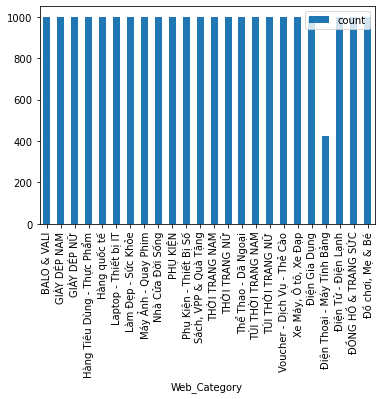

In [466]:
groups.plot(x='Web_Category', y = 'count', kind = 'bar')

3/ How many sellers are there on Tiki?


In [508]:
groups = merge_df1.groupby(['seller_product_id']).size().reset_index().rename(columns = {0: 'count'})
groups

,seller_product_id,count
0,20909,1
1,27325,1
2,30483,1
3,39001,1
4,41895,1
...,...,...
21816,75301300,1
21817,75309212,1
21818,75313507,2
21819,75320529,1


In [509]:
groups[groups['count'] > 2]

,seller_product_id,count
755,898351,3
2628,10761952,3
5328,28035805,3
7715,44025012,3
9001,49164251,3
10039,51692131,3
11551,54901779,3
13156,57531740,3
16712,68119015,3
17096,68484747,3


In [510]:
seller_product = groups.groupby(['count']).size().reset_index().rename(columns = {0: 'dup_count'})
cols = ['Number of Products', 'Number of Sellets']
seller_product.columns = cols
seller_product

,Number of Products,Number of Sellets
0,1,20229
1,2,1580
2,3,12


There are 21 821 sellers on Tiki. There are 1580 sellers that have 2 products appearing on Tiki. There are 12 sellers that have 3 projects app

4/ How many brands in Tiki? Name top 10 brands with the most products?

In [530]:
brandNotNull = merge_df1[merge_df1['brand_name'] != 'nan']
brandNotNull

,id,sku,name,url_key,url_path,type,brand_name,short_description,price,list_price,...,stock_item,salable_type,seller_product_id,Web_Category,Page_Loop,installment_info,bundle_deal,freegift_items,author_name,book_cover
0,25730627,7578609335289,Điện Thoại Nokia 105 Dual Sim (2019) - Hàng Ch...,dien-thoai-nokia-105-dual-sim-2019-hang-chinh-...,dien-thoai-nokia-105-dual-sim-2019-hang-chinh-...,configurable,Nokia,"Thiết kế nhỏ gọn, đẹp mắt\nĐiện Thoại Nokia 10...",321000,360000,...,"{'qty': 82, 'min_sale_qty': 1, 'max_sale_qty':...",,42932547,Điện Thoại - Máy Tính Bảng,1,nan,nan,nan,nan,nan
1,37694867,9953326620289,Điện thoại Vivo Y11 (3GB/32GB) - Hàng chính hãng,dien-thoai-vivo-y11-hang-chinh-hang-p37694867,dien-thoai-vivo-y11-hang-chinh-hang-p37694867....,configurable,Vivo,"Thiết kế sang trọng, sắc màu huyền ảo\nĐiện th...",2550000,2990000,...,"{'qty': 46, 'min_sale_qty': 1, 'max_sale_qty':...",,37694871,Điện Thoại - Máy Tính Bảng,1,nan,nan,nan,nan,nan
2,71197117,6411469851647,Điện Thoại iPhone 12 Pro Max 256GB - Hàng Chín...,dien-thoai-iphone-12-pro-max-256gb-hang-chinh-...,dien-thoai-iphone-12-pro-max-256gb-hang-chinh-...,configurable,Apple,iPhone 12 Pro Max 256GB - Nâng tầm đẳng cấp sử...,35490000,37990000,...,"{'qty': 2, 'min_sale_qty': 1, 'max_sale_qty': ...",,70771667,Điện Thoại - Máy Tính Bảng,1,"{'price': 5915000, 'month': '6', 'redirect_url...",nan,nan,nan,nan
3,58259141,1510492616997,Điện Thoại Samsung Galaxy M31 (6GB/128GB) - Hà...,dien-thoai-samsung-galaxy-m31-6gb-128gb-hang-c...,dien-thoai-samsung-galaxy-m31-6gb-128gb-hang-c...,configurable,Samsung,\nMở Rộng Không Gian Trải Nghiệm Với Màn Hình ...,4690000,6490000,...,"{'qty': 704, 'min_sale_qty': 1, 'max_sale_qty'...",,58259143,Điện Thoại - Máy Tính Bảng,1,"{'price': 781667, 'month': '6', 'redirect_url'...",nan,nan,nan,nan
4,70771651,5659170738265,Điện Thoại iPhone 12 Pro Max 128GB - Hàng Chín...,dien-thoai-iphone-12-pro-max-128gb-hang-chinh-...,dien-thoai-iphone-12-pro-max-128gb-hang-chinh-...,configurable,Apple,iPhone 12 Pro Max 128GB - Nâng tầm đẳng cấp sử...,32890000,33990000,...,"{'qty': 98, 'min_sale_qty': 1, 'max_sale_qty':...",,73858203,Điện Thoại - Máy Tính Bảng,1,"{'price': 5481667, 'month': '6', 'redirect_url...",nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23420,19557897,8593450360722,Dây chuyền nam Rồng vàng mạ Vàng 24k MD11,day-chuyen-nam-rong-vang-ma-vang-24k-md11-p195...,day-chuyen-nam-rong-vang-ma-vang-24k-md11-p195...,simple,OEM,[ CÁCH ĐỔI VẬN đơn giản bằng cách đeo TRANG SỨ...,232000,900000,...,"{'qty': 100, 'min_sale_qty': 1, 'max_sale_qty'...",,75186210,ĐỒNG HỒ & TRANG SỨC,21,nan,nan,nan,nan,nan
23421,36079799,1726714764135,Đồng Hồ Nam Curren Chống Nước Dây Da Cao Cấp A...,dong-ho-nam-curren-chong-nuoc-day-da-cao-cap-a...,dong-ho-nam-curren-chong-nuoc-day-da-cao-cap-a...,simple,CURREN,Đồng Hồ Nam Curren Chống Nước Dây Da Cao Cấp A...,518500,650000,...,"{'qty': 7, 'min_sale_qty': 1, 'max_sale_qty': ...",,36079800,ĐỒNG HỒ & TRANG SỨC,21,nan,nan,nan,nan,nan
23422,32215461,2303277516754,nhẫn nam quân đội mỹ -không đen -không bay màu...,nhan-nam-quan-doi-my-khong-den-khong-bay-mau-k...,nhan-nam-quan-doi-my-khong-den-khong-bay-mau-k...,configurable,OEM,"p style""text-align: justify; background: white...",790000,980000,...,"{'qty': 2, 'min_sale_qty': 1, 'max_sale_qty': ...",,32215469,ĐỒNG HỒ & TRANG SỨC,21,nan,nan,nan,nan,nan
23423,2615943,4033972244253,Bông Tai Mạ Bạc Heart Layer Pearl Tatiana BB2839,bong-tai-ma-bac-heart-layer-pearl-tatiana-bb28...,bong-tai-ma-bac-heart-layer-pearl-tatiana-bb28...,configurable,Tatiana,\n \n \n Bông Tai Mạ Bạc Heart Layer Pearl Tat...,9000,83000,...,"{'qty': 5, 'min_sale_qty': 1, 'max_sale_qty': ...",,2714889,ĐỒNG HỒ & TRANG SỨC,21,nan,nan,nan,nan,nan


In [ ]:
There are 21512  brand names

In [531]:
groups = brandNotNull.groupby(['Web_Category', 'brand_name']).size().reset_index().rename(columns = {0: 'dup_count'})
groups

,Web_Category,brand_name,dup_count
0,BALO & VALI,\tOEM,1
1,BALO & VALI,14.Dec,1
2,BALO & VALI,4U,8
3,BALO & VALI,5THEWAY,3
4,BALO & VALI,ALUVI,1
...,...,...,...
3020,"Đồ chơi, Mẹ & Bé",fatz baby,1
3021,"Đồ chơi, Mẹ & Bé",finish,15
3022,"Đồ chơi, Mẹ & Bé",miDoctor,9
3023,"Đồ chơi, Mẹ & Bé",sunmum,5


In [532]:
cat_brand = groups.groupby(['Web_Category']).size().reset_index().rename(columns = {0: 'Number_Brand_Names'})
cat_brand

,Web_Category,Number_Brand_Names
0,BALO & VALI,99
1,GIÀY DÉP NAM,95
2,GIÀY DÉP NỮ,64
3,Hàng Tiêu Dùng - Thực Phẩm,328
4,Hàng quốc tế,222
5,Laptop - Thiết bị IT,122
6,Làm Đẹp - Sức Khỏe,287
7,Máy Ảnh - Quay Phim,121
8,Nhà Cửa Đời Sống,134
9,PHỤ KIỆN,99


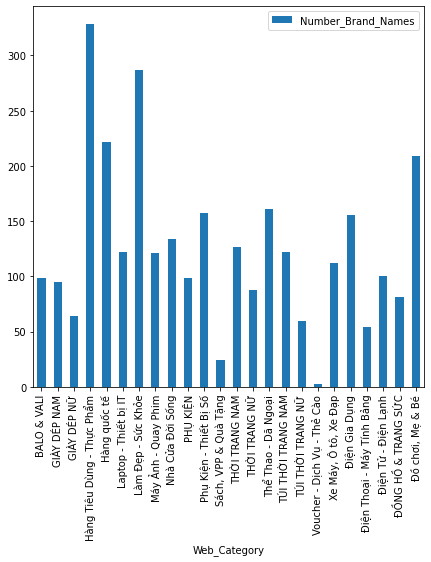

In [536]:
cat_brand.plot(x = 'Web_Category', y = 'Number_Brand_Names', kind = 'bar', figsize=(7, 7))

"Hàng Tiêu Dùng - Thực Phẩm", "Làm Đẹp - Sức Khỏe" have the most brand names, while "Sách, VPP, & Quà Tặng" and "Voucher - Dịch Vụ - Thẻ Cào" have the least brand names

5/ Comments

In [540]:
cat_sumReview = merge_df1.groupby(['Web_Category'])['review_count'].sum().reset_index()
cat_sumReview

,Web_Category,review_count
0,BALO & VALI,35373
1,GIÀY DÉP NAM,24336
2,GIÀY DÉP NỮ,21148
3,Hàng Tiêu Dùng - Thực Phẩm,98651
4,Hàng quốc tế,14737
5,Laptop - Thiết bị IT,59960
6,Làm Đẹp - Sức Khỏe,184081
7,Máy Ảnh - Quay Phim,25064
8,Nhà Cửa Đời Sống,158568
9,PHỤ KIỆN,29492


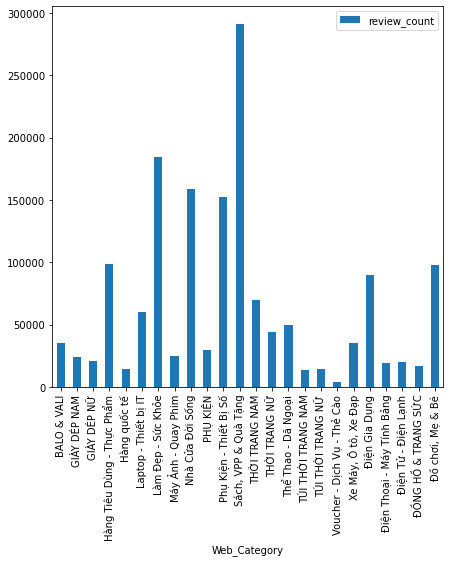

In [541]:
cat_sumReview.plot(x = 'Web_Category', y = 'review_count', kind = 'bar', figsize = (7,7))

"Sách, VPP & Quà Tặng" and "Làm Đẹp - Sức Khỏe" have the most number of reviews, while "Voucher - Dịch Vụ - Thẻ Cào" have the least number of reviews.